# CSC1142 - Cloud Assignment
# **Topic: - London Weather & TfL Cycle Hires (using Apache Spark)**

This notebook implements a complete **Spark-based data pipeline** that:

- Loads **London daily weather data** (1979 - 2023)
- Loads **TfL Santander Cycle Hire daily usage**
- Cleans and transforms both datasets using **Apache Spark**
- Performs **null handling**, **outlier removal**, and **feature engineering**
- Joins them into a single **analytical dataset**
- Produces several **visualisations** using matplotlib (no Pandas)

## 1. Environment Setup & Spark Session

In [3]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import mean, stddev
import matplotlib.pyplot as plt

# Start Spark session
spark = (
    SparkSession.builder
    .appName("CloudProject_LondonWeather_TfL_Final")
    .getOrCreate()
)

print("Spark version:", spark.version)

# File paths (edit these if needed)
weather_path = "london_weather_data_1979_to_2023.csv"
bikes_path   = "tfl-daily-cycle-hires.csv.csv"

print("Weather path:", weather_path)
print("Bikes path:", bikes_path)


Spark version: 3.5.7
Weather path: london_weather_data_1979_to_2023.csv
Bikes path: tfl-daily-cycle-hires.csv.csv


## 2. Load & Inspect Weather Data (Spark)

In [4]:
# Load raw weather CSV into Spark
weather_raw = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(weather_path)
)

print("Weather rows:", weather_raw.count())
weather_raw.printSchema()
weather_raw.show(5)


Weather rows: 16436
root
 |-- DATE: integer (nullable = true)
 |-- TX: double (nullable = true)
 |-- Q_TX: integer (nullable = true)
 |-- TN: double (nullable = true)
 |-- Q_TN: integer (nullable = true)
 |-- TG: double (nullable = true)
 |-- Q_TG: integer (nullable = true)
 |-- SS: double (nullable = true)
 |-- Q_SS: integer (nullable = true)
 |-- SD: double (nullable = true)
 |-- Q_SD: integer (nullable = true)
 |-- RR: double (nullable = true)
 |-- Q_RR: integer (nullable = true)
 |-- QQ: double (nullable = true)
 |-- Q_QQ: integer (nullable = true)
 |-- PP: double (nullable = true)
 |-- Q_PP: integer (nullable = true)
 |-- HU: double (nullable = true)
 |-- Q_HU: integer (nullable = true)
 |-- CC: double (nullable = true)
 |-- Q_CC: integer (nullable = true)

+--------+----+----+-----+----+-----+----+----+----+---+----+---+----+----+----+-------+----+----+----+---+----+
|    DATE|  TX|Q_TX|   TN|Q_TN|   TG|Q_TG|  SS|Q_SS| SD|Q_SD| RR|Q_RR|  QQ|Q_QQ|     PP|Q_PP|  HU|Q_HU| CC|Q_CC|
+

In [5]:
from pyspark.sql.functions import col, sum as spark_sum

weather_nulls = weather_raw.select([
    spark_sum(col(c).isNull().cast("int")).alias(c + "_nulls")
    for c in weather_raw.columns
])

weather_nulls.show()

+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+
|DATE_nulls|TX_nulls|Q_TX_nulls|TN_nulls|Q_TN_nulls|TG_nulls|Q_TG_nulls|SS_nulls|Q_SS_nulls|SD_nulls|Q_SD_nulls|RR_nulls|Q_RR_nulls|QQ_nulls|Q_QQ_nulls|PP_nulls|Q_PP_nulls|HU_nulls|Q_HU_nulls|CC_nulls|Q_CC_nulls|
+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+
|         0|       0|         0|       0|         0|      29|         0|       0|         0|    1075|         0|       0|         0|      25|         0|       4|         0|      57|         0|      18|         0|
+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+-------

## 3. Clean Weather Data + Null Handling + Feature Engineering (outliers removal)

In [6]:
# Basic cleaning & unit conversion
weather_clean = (
    weather_raw
    .withColumn("date", F.to_date(F.col("DATE").cast("string"), "yyyyMMdd"))
    .withColumn("tmax_c",  F.col("TX") / 10.0)
    .withColumn("tmin_c",  F.col("TN") / 10.0)
    .withColumn("tmean_c", F.col("TG") / 10.0)
    .withColumn("rain_mm", F.col("RR") / 10.0)
    .withColumn("sun_hrs", F.col("SS") / 10.0)
    .select("date", "tmax_c", "tmin_c", "tmean_c", "rain_mm", "sun_hrs", "HU")
    .filter("date IS NOT NULL")
)

# Impute missing rainfall & sunshine with 0, and humidity with mean
avg_hu = weather_clean.select(F.mean("HU")).first()[0]

weather_clean = weather_clean.fillna({
    "rain_mm": 0.0,
    "sun_hrs": 0.0,
    "HU": avg_hu
})

weather_clean = weather_clean.filter("tmean_c IS NOT NULL")

# Advanced feature: feels-like temperature (simple approximation)
weather_clean = weather_clean.withColumn(
    "feels_like",
    (F.col("tmax_c") + F.col("tmin_c")) / 2 + 0.1 * F.col("HU")
)

weather_clean.printSchema()
weather_clean.show(5)


root
 |-- date: date (nullable = true)
 |-- tmax_c: double (nullable = true)
 |-- tmin_c: double (nullable = true)
 |-- tmean_c: double (nullable = true)
 |-- rain_mm: double (nullable = false)
 |-- sun_hrs: double (nullable = false)
 |-- HU: double (nullable = false)
 |-- feels_like: double (nullable = true)

+----------+------+------+-------+-------+-------+----+------------------+
|      date|tmax_c|tmin_c|tmean_c|rain_mm|sun_hrs|  HU|        feels_like|
+----------+------+------+-------+-------+-------+----+------------------+
|1979-01-01|   2.3|  -7.5|   -4.1|    0.4|    7.0|83.0| 5.700000000000001|
|1979-01-02|   1.6|  -7.5|   -2.6|    0.0|    1.7|76.0|              4.65|
|1979-01-03|   1.3|  -7.2|   -2.8|    0.0|    0.0|86.0|5.6499999999999995|
|1979-01-04|  -0.3|  -6.5|   -2.6|    0.0|    0.0|68.0| 3.400000000000001|
|1979-01-05|   5.6|  -1.4|   -0.8|    0.0|    2.0|73.0|               9.4|
+----------+------+------+-------+-------+-------+----+------------------+
only showing 

In [7]:
weather_nulls_after = weather_clean.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c + "_nulls")
    for c in weather_clean.columns
])

weather_nulls_after.show()

+----------+------------+------------+-------------+-------------+-------------+--------+----------------+
|date_nulls|tmax_c_nulls|tmin_c_nulls|tmean_c_nulls|rain_mm_nulls|sun_hrs_nulls|HU_nulls|feels_like_nulls|
+----------+------------+------------+-------------+-------------+-------------+--------+----------------+
|         0|           0|           0|            0|            0|            0|       0|               0|
+----------+------------+------------+-------------+-------------+-------------+--------+----------------+



## 4. Load & Clean TfL Cycle Hire Data (Spark Only)

In [8]:
# Load TfL daily cycle hires using Spark only
bikes_raw = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(bikes_path)
)

print("Raw TfL schema:")
bikes_raw.printSchema()
bikes_raw.show(5)

# Clean and prepare
bikes_clean = (
    bikes_raw
    .withColumn("date", F.to_date("Day", "dd/MM/yyyy"))
    .withColumn("hires", F.col("Number of Bicycle Hires"))
    .select("date", "hires")
    .filter("date IS NOT NULL AND hires IS NOT NULL AND hires > 0")
)

print("Bike rows before outlier removal:", bikes_clean.count())

# Outlier removal using 4*std rule
stats = bikes_clean.select(mean("hires").alias("mean"), stddev("hires").alias("std")).first()
mean_val, std_val = stats["mean"], stats["std"]

bikes_clean = bikes_clean.filter(
    (F.col("hires") > mean_val - 4*std_val) &
    (F.col("hires") < mean_val + 4*std_val)
)

print("Bike rows after outlier removal:", bikes_clean.count())
bikes_clean.show(5)


Raw TfL schema:
root
 |-- Day: string (nullable = true)
 |-- Number of Bicycle Hires: double (nullable = true)
 |-- _c2: string (nullable = true)

+----------+-----------------------+----+
|       Day|Number of Bicycle Hires| _c2|
+----------+-----------------------+----+
|30/07/2010|                 6897.0|NULL|
|31/07/2010|                 5564.0|NULL|
|01/08/2010|                 4303.0|NULL|
|02/08/2010|                 6642.0|NULL|
|03/08/2010|                 7966.0|NULL|
+----------+-----------------------+----+
only showing top 5 rows

Bike rows before outlier removal: 4081
Bike rows after outlier removal: 4078
+----------+------+
|      date| hires|
+----------+------+
|2010-07-30|6897.0|
|2010-07-31|5564.0|
|2010-08-01|4303.0|
|2010-08-02|6642.0|
|2010-08-03|7966.0|
+----------+------+
only showing top 5 rows



In [9]:
from pyspark.sql.functions import col, sum as spark_sum

print("Checking BIKES DATA for remaining nulls...")

bikes_nulls_after = bikes_clean.select([
    spark_sum(col(c).isNull().cast("int")).alias(f"{c}_nulls")
    for c in bikes_clean.columns
])

bikes_nulls_after.show()

Checking BIKES DATA for remaining nulls...
+----------+-----------+
|date_nulls|hires_nulls|
+----------+-----------+
|         0|          0|
+----------+-----------+



## 5. Join Weather & Bike Data + Feature Engineering

In [10]:
# Join on date
joined = weather_clean.join(bikes_clean, "date", "inner")

# Add time-based & categorical features
joined = (
    joined
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .withColumn("dayofweek", F.date_format("date", "EEEE"))
    .withColumn("is_weekend", F.col("dayofweek").isin("Saturday", "Sunday").cast("int"))
    .withColumn("rain_flag", (F.col("rain_mm") > 0.2).cast("int"))
    .withColumn(
        "temp_band",
        F.when(F.col("tmean_c") < 5,  "Very cold")
         .when(F.col("tmean_c") < 10, "Cold")
         .when(F.col("tmean_c") < 15, "Mild")
         .when(F.col("tmean_c") < 20, "Warm")
         .otherwise("Hot")
    )
)

print("Joined rows:", joined.count())
joined.printSchema()
joined.orderBy("date").show(5)


Joined rows: 4078
root
 |-- date: date (nullable = true)
 |-- tmax_c: double (nullable = true)
 |-- tmin_c: double (nullable = true)
 |-- tmean_c: double (nullable = true)
 |-- rain_mm: double (nullable = false)
 |-- sun_hrs: double (nullable = false)
 |-- HU: double (nullable = false)
 |-- feels_like: double (nullable = true)
 |-- hires: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- rain_flag: integer (nullable = false)
 |-- temp_band: string (nullable = false)

+----------+------+------+-------+-------+-------+----+------------------+------+----+-----+---------+----------+---------+---------+
|      date|tmax_c|tmin_c|tmean_c|rain_mm|sun_hrs|  HU|        feels_like| hires|year|month|dayofweek|is_weekend|rain_flag|temp_band|
+----------+------+------+-------+-------+-------+----+------------------+------+----+-----+---------+----------+--------

## 6. Null Check on Final Analytical Dataset

In [11]:
# Check remaining nulls in joined dataset
null_counts = joined.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c + "_nulls")
    for c in joined.columns
])
null_counts.show()


+----------+------------+------------+-------------+-------------+-------------+--------+----------------+-----------+----------+-----------+---------------+----------------+---------------+---------------+
|date_nulls|tmax_c_nulls|tmin_c_nulls|tmean_c_nulls|rain_mm_nulls|sun_hrs_nulls|HU_nulls|feels_like_nulls|hires_nulls|year_nulls|month_nulls|dayofweek_nulls|is_weekend_nulls|rain_flag_nulls|temp_band_nulls|
+----------+------------+------------+-------------+-------------+-------------+--------+----------------+-----------+----------+-----------+---------------+----------------+---------------+---------------+
|         0|           0|           0|            0|            0|            0|       0|               0|          0|         0|          0|              0|               0|              0|              0|
+----------+------------+------------+-------------+-------------+-------------+--------+----------------+-----------+----------+-----------+---------------+---------------

## 7. Visualisation 1 - Daily Hire Trend (Spark → lists → matplotlib)

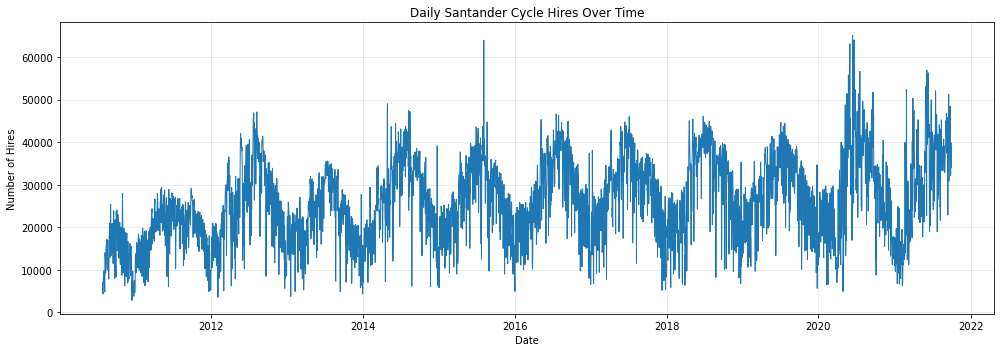

In [12]:
# Extract data for plotting
data = joined.select("date", "hires").orderBy("date").collect()
dates = [row["date"] for row in data]
hires = [row["hires"] for row in data]

plt.figure(figsize=(14,5))
plt.plot(dates, hires, linewidth=1)
plt.title("Daily Santander Cycle Hires Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Hires")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Visualisation 2 - Monthly Average Hires & Temperature

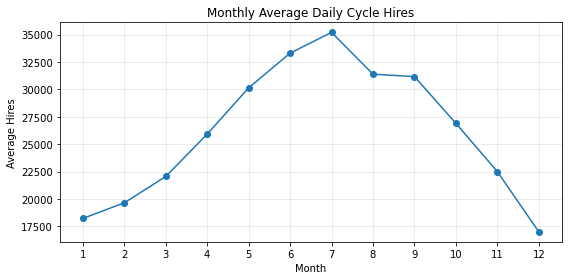

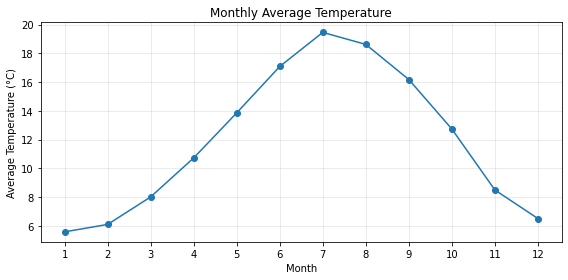

In [13]:
# Aggregate by month across all years
monthly = (
    joined
    .groupBy("month")
    .agg(
        F.avg("hires").alias("avg_hires"),
        F.avg("tmean_c").alias("avg_temp")
    )
    .orderBy("month")
    .collect()
)

months = [row["month"] for row in monthly]
avg_hires = [row["avg_hires"] for row in monthly]
avg_temp = [row["avg_temp"] for row in monthly]

# Plot average hires
plt.figure(figsize=(8,4))
plt.plot(months, avg_hires, marker="o")
plt.title("Monthly Average Daily Cycle Hires")
plt.xlabel("Month")
plt.ylabel("Average Hires")
plt.xticks(range(1,13))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot average temperature
plt.figure(figsize=(8,4))
plt.plot(months, avg_temp, marker="o")
plt.title("Monthly Average Temperature")
plt.xlabel("Month")
plt.ylabel("Average Temperature (°C)")
plt.xticks(range(1,13))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Visualisation 3 - Temperature vs Hires (Scatter Plot)

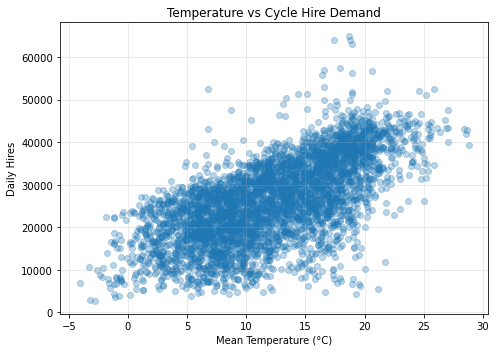

In [14]:
data_temp = joined.select("tmean_c", "hires").collect()
temps = [row["tmean_c"] for row in data_temp]
hires2 = [row["hires"] for row in data_temp]

plt.figure(figsize=(7,5))
plt.scatter(temps, hires2, alpha=0.3)
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Daily Hires")
plt.title("Temperature vs Cycle Hire Demand")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 10. Visualisation 4 - Effect of Rain on Cycle Hires

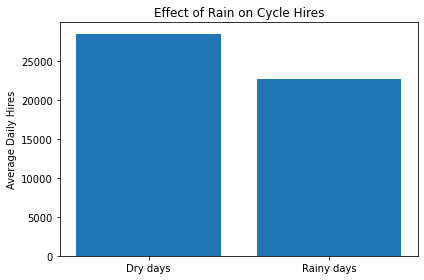

In [15]:
rain_stats_rows = (
    joined
    .groupBy("rain_flag")
    .agg(F.avg("hires").alias("avg_hires"))
    .orderBy("rain_flag")
    .collect()
)

labels = ["Dry days", "Rainy days"]
values = [rain_stats_rows[0]["avg_hires"], rain_stats_rows[1]["avg_hires"]]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel("Average Daily Hires")
plt.title("Effect of Rain on Cycle Hires")
plt.tight_layout()
plt.show()


## 11. Visualisation 5 - Average Hires by Day of Week

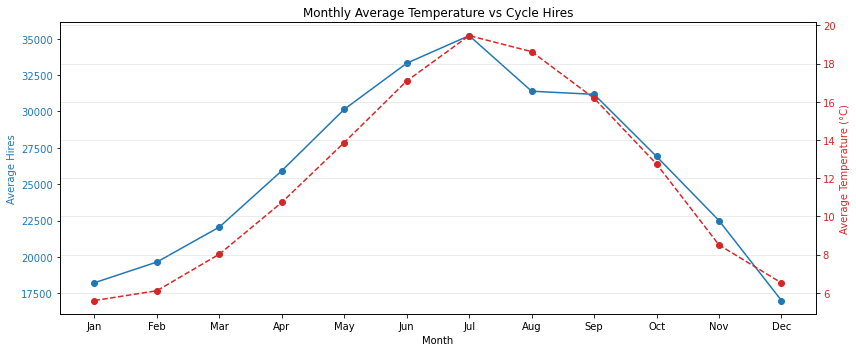

In [21]:
fig, ax1 = plt.subplots(figsize=(12,5))

# Plot average hires
ax1.set_xlabel("Month")
ax1.set_ylabel("Average Hires", color="tab:blue")
ax1.plot(months, avg_hires, marker="o", color="tab:blue", label="Average Hires")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Replace numeric ticks with month names
month_labels = ["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]
ax1.set_xticks(months)
ax1.set_xticklabels(month_labels)

# Second y-axis for temperature
ax2 = ax1.twinx()
ax2.set_ylabel("Average Temperature (°C)", color="tab:red")
ax2.plot(months, avg_temp, marker="o", linestyle="--", color="tab:red", label="Average Temperature")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title + layout
plt.title("Monthly Average Temperature vs Cycle Hires")
fig.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


## 12. Correlation Analysis (Spark)

In [20]:
corr_cols = ["hires", "tmean_c", "rain_mm", "sun_hrs", "HU", "feels_like"]
for colname in corr_cols[1:]:
    corr_val = joined.stat.corr("hires", colname)
    print(f"Correlation between hires and {colname}: {corr_val}")


Correlation between hires and tmean_c: 0.6483028299764795
Correlation between hires and rain_mm: -0.24568512790374092
Correlation between hires and sun_hrs: 0.5315183373068391
Correlation between hires and HU: -0.5340292920453926
Correlation between hires and feels_like: 0.5677772719690436


## 13. Conclusions

- There is a **clear seasonal pattern**: cycle hires increase in warmer months and drop in winter.
- **Temperature** has a positive correlation with cycle hire demand.
- **Rainfall** reduces demand on average (rainy days show fewer hires than dry days).
- **Weekday patterns** reveal commuting vs leisure usage (e.g. higher on weekdays if commuting dominates).
- The pipeline:
  - Uses **Spark** for all ETL steps (no Pandas),
  - Integrates **two large public datasets**,
  - Handles **nulls**, **outliers**, and **feature engineering**,
  - Produces a **joined analytical dataset** suitable for dashboards or modelling.